https://www.ebi.ac.uk/pride/archive/projects/PXD042416

https://www.ebi.ac.uk/pride/archive/projects/PXD009449

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_tr = pd.read_csv("data/prosit_ptm_2020.csv")

In [3]:
df_tr.fillna("",inplace=True)
for g in df_tr.groupby("seq"):
    print(g)

('AAGGAPLSCFICGGGIGR',                      seq                                   modifications  \
2503  AAGGAPLSCFICGGGIGR  18|Methyl|9|Carbamidomethyl|12|Carbamidomethyl   

            tr  
2503  44.53325  )
('AAGGAPLSCFICGGGIGRGK',                        seq                                      modifications  \
182   AAGGAPLSCFICGGGIGRGK     18|Methyl|9|Carbamidomethyl|12|Carbamidomethyl   
705   AAGGAPLSCFICGGGIGRGK   18|Dimethyl|9|Carbamidomethyl|12|Carbamidomethyl   
3031  AAGGAPLSCFICGGGIGRGK               9|Carbamidomethyl|12|Carbamidomethyl   
5224  AAGGAPLSCFICGGGIGRGK  18|Deamidated|9|Carbamidomethyl|12|Carbamidome...   

             tr  
182   40.843250  
705   41.188375  
3031  40.492750  
5224  43.764250  )
('AAGPSLSHTSGGTQSK',                    seq modifications         tr
1126  AAGPSLSHTSGGTQSK                11.674375)
('AAGQPYEQHAK',               seq modifications         tr
1653  AAGQPYEQHAK                10.841250
2696  AAGQPYEQHAK     6|Phospho  11.039525
5080

In [4]:
# Separate unmodified and modified peptides
df_unmod = df_tr[df_tr["modifications"] == ""].rename(columns={"tr": "tr_unmod"})
df_mod = df_tr[df_tr["modifications"] != ""]

# Merge on sequence to get corresponding unmodified tr for each modified one
df_merged = pd.merge(df_mod, df_unmod[["seq", "tr_unmod"]], on="seq", how="left")

# Calculate RT difference
df_merged["delta_tr"] = df_merged["tr"] - df_merged["tr_unmod"]

# Optional: sort for readability
df_merged = df_merged.sort_values(by="seq")
print(df_merged)

                       seq                                      modifications  \
2170    AAGGAPLSCFICGGGIGR     18|Methyl|9|Carbamidomethyl|12|Carbamidomethyl   
4494  AAGGAPLSCFICGGGIGRGK  18|Deamidated|9|Carbamidomethyl|12|Carbamidome...   
2477  AAGGAPLSCFICGGGIGRGK               9|Carbamidomethyl|12|Carbamidomethyl   
58    AAGGAPLSCFICGGGIGRGK     18|Methyl|9|Carbamidomethyl|12|Carbamidomethyl   
554   AAGGAPLSCFICGGGIGRGK   18|Dimethyl|9|Carbamidomethyl|12|Carbamidomethyl   
...                    ...                                                ...   
4352            YTTNNSSEQR                                            1|Nitro   
4362            YVGESEANIR                                            1|Nitro   
2352            YVGESEANIR                                          1|Phospho   
2211            YVHADAPTNK                                            1|Nitro   
2298            YVHADAPTNK                                          1|Phospho   

             tr  tr_unmod  

C:\Users\robbi\AppData\Local\Temp\ipykernel_48300\3391743090.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods["mod_types"] = df_mods["modifications"].apply(extract_mod_types)


<Figure size 1200x600 with 0 Axes>

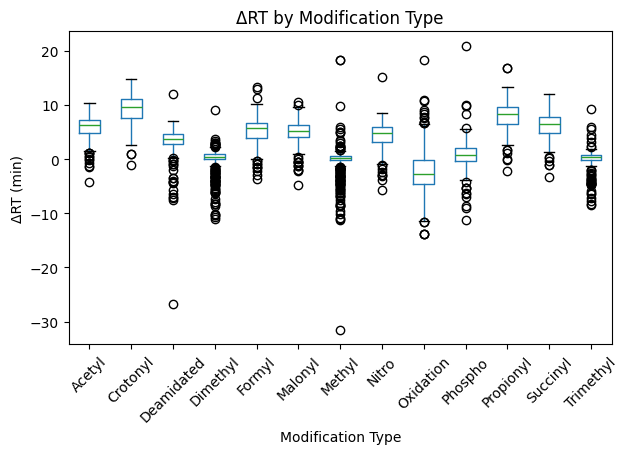

In [5]:
# Step 1: Remove rows with missing delta_tr (i.e., no unmodified reference)
df_mods = df_merged.dropna(subset=["delta_tr"])

# Step 2: Extract only the modification types from the modification string
# Example: "18|Methyl|9|Carbamidomethyl" -> ["Methyl", "Carbamidomethyl"]
def extract_mod_types(mod_str):
    if not mod_str:
        return []
    parts = mod_str.split('|')
    return [parts[i] for i in range(1, len(parts), 2)]

# Create a column of modification lists
df_mods["mod_types"] = df_mods["modifications"].apply(extract_mod_types)

# Step 3: Explode into separate rows for each modification type
df_exploded = df_mods.explode("mod_types")

# Step 4: Grouped boxplot
plt.figure(figsize=(12, 6))
df_exploded.boxplot(column="delta_tr", by="mod_types", grid=False)
plt.title("ΔRT by Modification Type")
plt.suptitle("")  # Remove default pandas title
plt.xlabel("Modification Type")
plt.ylabel("ΔRT (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\robbi\AppData\Local\Temp\ipykernel_48300\3835825143.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_vp_filtered = df_vp.groupby("mod_types").apply(filter_outliers).reset_index(drop=True)


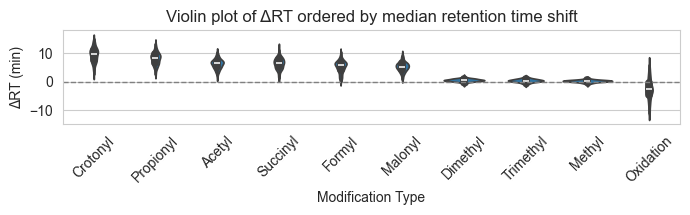

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_vp = df_exploded.dropna(subset=["delta_tr", "mod_types"])

# Limit to top modifications for clarity
top_mods = df_vp["mod_types"].value_counts().nlargest(10).index
df_vp = df_vp[df_vp["mod_types"].isin(top_mods)]

# Function to identify outliers by IQR for each group
def filter_outliers(group):
    q1 = group["delta_tr"].quantile(0.25)
    q3 = group["delta_tr"].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Return group without outliers
    return group[(group["delta_tr"] >= lower_bound) & (group["delta_tr"] <= upper_bound)]

# Filter outliers for violin plot only
df_vp_filtered = df_vp.groupby("mod_types").apply(filter_outliers).reset_index(drop=True)

sns.set_style("whitegrid")

# Calculate median ΔRT per modification type
mod_order = df_vp_filtered.groupby("mod_types")["delta_tr"].median().sort_values(ascending=False).index

plt.figure(figsize=(7, 2.25))

# Pass the sorted order to violinplot
sns.violinplot(x="mod_types", y="delta_tr", data=df_vp_filtered, order=mod_order)

# Optional: show all points with swarmplot (uncomment if desired)
# sns.swarmplot(x="mod_types", y="delta_tr", data=df_vp, order=mod_order, color='k', size=2, alpha=0.6)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(rotation=45)
plt.xlabel("Modification Type")
plt.ylabel("ΔRT (min)")
plt.title("Violin plot of ΔRT ordered by median retention time shift")
plt.tight_layout()
plt.savefig("img/rt_shift.svg")
plt.show()

In [7]:
df_ccs = pd.read_csv("data/peprec_CCS_v4.csv")
df_ccs["seq"] = df_ccs["seq"]+"|"+df_ccs["charge"].astype(str)
df_ccs = df_ccs[df_ccs["charge"] == 2]
df_ccs["modifications"].replace("Not modified","",inplace=True)
df_ccs

C:\Users\robbi\AppData\Local\Temp\ipykernel_48300\2563167726.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ccs["modifications"].replace("Not modified","",inplace=True)


,seq,modifications,charge,tr
0,AAAAAAAAAAAAAAAAGATCLER|2,20|Carbamidomethyl,2,465.378594
2,AAAAAAAAAAAAAAAASAGGK|2,,2,441.653611
4,AAAAAAAAAAAAAAAGAGAGAK|2,,2,472.328659
6,AAAAAAAAAAAAAAASGFAYPGTSER|2,,2,570.272598
10,AAAAAAAAAAGAAGGR|2,0|Acetyl,2,411.237967
...,...,...,...,...
1117078,VLSAADKGNVK|2,0|Acetyl,2,363.603658
1117084,VYCDMNTENGGWTVIQNR|2,0|Acetyl|5|Oxidation,2,479.862788
1117085,WAGIKTEGGL|2,0|Acetyl,2,358.291678
1117087,YSQAACSDSAQGSDVSLTA|2,0|Acetyl,2,451.799658


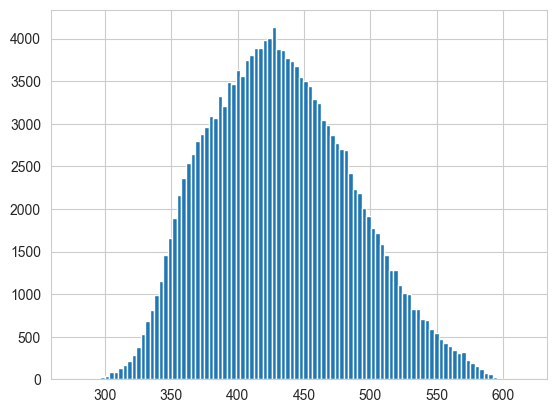

In [8]:
# Separate unmodified and modified peptides
df_unmod_ccs = df_ccs[df_ccs["modifications"] == ""].rename(columns={"tr": "tr_unmod"})
df_mod_ccs = df_ccs[df_ccs["modifications"] != ""]

# Merge on sequence to get corresponding unmodified tr for each modified one
df_merged_ccs = pd.merge(df_mod_ccs, df_unmod_ccs[["seq", "tr_unmod"]], on="seq", how="left")

# Calculate RT difference
df_merged_ccs["delta_tr"] = df_merged_ccs["tr"] - df_merged_ccs["tr_unmod"]

# Optional: sort for readability
df_merged_ccs = df_merged_ccs.sort_values(by="seq")
plt.hist(df_merged_ccs["tr"],bins=100)
plt.show()

C:\Users\robbi\AppData\Local\Temp\ipykernel_48300\2119830062.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mods["mod_types"] = df_mods["modifications"].apply(extract_mod_types)


<Figure size 1200x600 with 0 Axes>

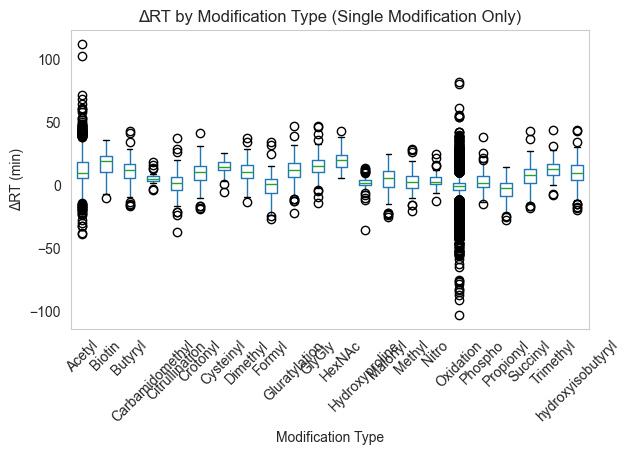

In [12]:
import matplotlib.pyplot as plt

# Step 1: Remove rows with missing delta_tr (i.e., no unmodified reference)
df_mods = df_merged_ccs.dropna(subset=["delta_tr"])

# Step 2: Extract only the modification types from the modification string
def extract_mod_types(mod_str):
    if not mod_str:
        return []
    parts = mod_str.split('|')
    return [parts[i] for i in range(1, len(parts), 2)]

df_mods["mod_types"] = df_mods["modifications"].apply(extract_mod_types)

# Step 2.5: Filter for peptides with exactly one modification
df_single_mod = df_mods[df_mods["mod_types"].apply(len) == 1].copy()

# Step 3: Explode into separate rows for each modification type (only one per row now)
df_exploded = df_single_mod.explode("mod_types")

# Step 4: Grouped boxplot of ΔRT by modification type
plt.figure(figsize=(12, 6))
df_exploded.boxplot(column="delta_tr", by="mod_types", grid=False)
plt.title("ΔRT by Modification Type (Single Modification Only)")
plt.suptitle("")  # Remove default pandas title
plt.xlabel("Modification Type")
plt.ylabel("ΔRT (min)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\robbi\AppData\Local\Temp\ipykernel_48300\236423855.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_vp_filtered = df_vp.groupby("mod_types").apply(filter_outliers).reset_index(drop=True)


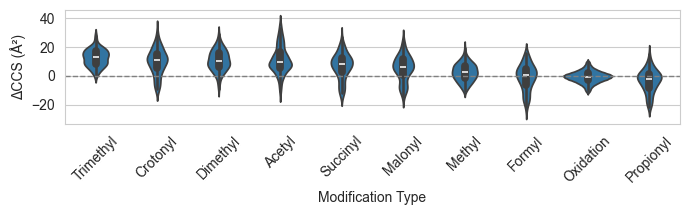

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_vp = df_exploded.dropna(subset=["delta_tr", "mod_types"])

# Limit to top modifications for clarity
#top_mods = df_vp["mod_types"].value_counts().nlargest(10).index
df_vp = df_vp[df_vp["mod_types"].isin(top_mods)]

# Function to identify outliers by IQR for each group
def filter_outliers(group):
    q1 = group["delta_tr"].quantile(0.25)
    q3 = group["delta_tr"].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Return group without outliers
    return group[(group["delta_tr"] >= lower_bound) & (group["delta_tr"] <= upper_bound)]

# Filter outliers for violin plot only
df_vp_filtered = df_vp.groupby("mod_types").apply(filter_outliers).reset_index(drop=True)

sns.set_style("whitegrid")

# Calculate median ΔRT per modification type
mod_order = df_vp_filtered.groupby("mod_types")["delta_tr"].median().sort_values(ascending=False).index

plt.figure(figsize=(7,2.25))

# Pass the sorted order to violinplot
sns.violinplot(x="mod_types", y="delta_tr", data=df_vp_filtered, order=mod_order)

# Optional: show all points with swarmplot (uncomment if desired)
# sns.swarmplot(x="mod_types", y="delta_tr", data=df_vp, order=mod_order, color='k', size=2, alpha=0.6)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xticks(rotation=45)
plt.xlabel("Modification Type")
plt.ylabel("ΔCCS (Å²)")
plt.tight_layout()
plt.savefig("img/ccs_shift.svg")
plt.show()